In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import plot_tree, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score, cohen_kappa_score, matthews_corrcoef, log_loss, r2_score,
    mean_squared_error, mean_absolute_error
)
from google.colab import drive
from sklearn import metrics

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Random Forest Classifier classifies whether a project will exceed 50% of initially agreed-upon price
projects = pd.read_csv("/content/drive/MyDrive/IEOR 115 Team/Interesting Queries/project.csv")
invoices = pd.read_csv("/content/drive/MyDrive/IEOR 115 Team/Interesting Queries/invoice.csv")
bids = pd.read_csv("/content/drive/MyDrive/IEOR 115 Team/Interesting Queries/bid.csv")
projects_and_invoices = invoices #projects.merge(invoices, left_on="PID", right_on="associatedWithPID")
projects_with_bids = projects_and_invoices.merge(bids, left_on="associatedWithPID", right_on="associatedWithPID")#.drop(columns=["associatedWithPID"])
projects_with_bids.drop(columns=["associatedWithPID", "BidID", "requestedByClientID", "overseeByEmpID", "Date", "InvoiceID", 'generatedByEmpID'], inplace=True)
#projects_with_bids["StartDate"] = pd.to_datetime(projects_with_bids["StartDate"])
#projects_with_bids["Date"] = pd.to_datetime(projects_with_bids["Date"])
#projects_with_bids["ClientID"] = projects_with_bids["ClientID"].to_string()
projects_with_bids.rename(columns={"Amount": "TotalCost"}, inplace=True)
projects_with_bids = pd.get_dummies(projects_with_bids)
X_train, X_test, y_train, y_test = train_test_split(projects_with_bids.drop(columns="TotalCost"), projects_with_bids["TotalCost"], test_size=0.33, random_state=42)

In [18]:
def OSR2(model, X_test, y_test, y_train):

    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)

    return (1 - SSE/SST)

In [4]:
# Basic metrics function
def basic_metrics(y_pred, y_true):
    '''
    Returns accuracy, TPR, FPR, precision, and F-1 score as a tuple
    '''
    acc = np.mean(y_pred == y_true)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    pre = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred, average='weighted')
    return (acc, tpr, fpr, pre, f1)

ValueError: ignored

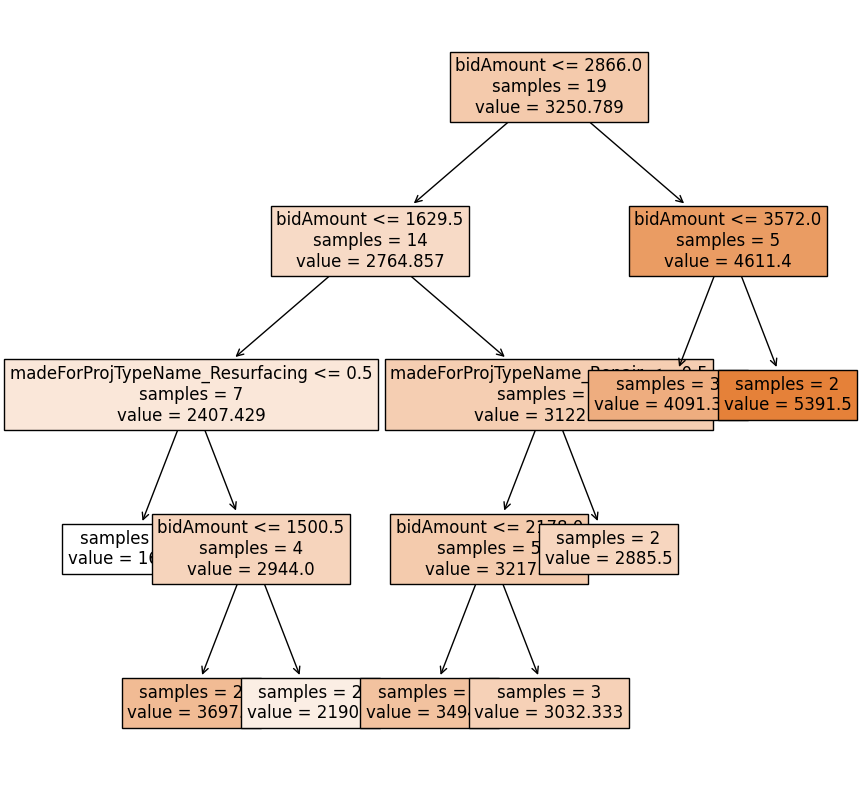

In [13]:
grid_values = {'ccp_alpha': np.linspace(0, 0.01, 11)}

dtc = DecisionTreeRegressor(random_state=42, min_samples_leaf=2)
dtc_cv = GridSearchCV(dtc, param_grid=grid_values, cv=5, error_score='raise').fit(X_train, y_train)
plt.figure(figsize=(10,10))
plot_tree(dtc_cv.best_estimator_,
          feature_names=X_train.columns,
          class_names=['0','1'],
          filled=True,
          impurity=False,
          fontsize=12)

dtc = dtc_cv.best_estimator_
dtc_y_pred = dtc.predict(X_test)
dtc_acc = r2_score(y_test, dtc_y_pred)
#cm = confusion_matrix(y_test, dtc_y_pred)
# tn, fp, fn, tp = cm.ravel()
# dtc_TPR = tp / (tp + fn)
# dtc_FPR = fp / (fp + tn)
# dtc_PRE = tp / (tp + fp)
# print ("Confusion Matrix: \n", cm)
# print ("\nAccuracy:", dtc_acc)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

# cm_display.plot()
# plt.show()

acc, tpr, fpr, pre, f1 = basic_metrics(dtc_y_pred, y_test)
comparison_data = {'Decision Tree': [acc, tpr, fpr, pre, f1]
                  }

comparison_table = pd.DataFrame(data=comparison_data, index=['Accuracy', 'TPR', 'FPR','PRE', 'F1 Score']).transpose()
comparison_table.style.set_properties(**{'font-size': '12pt',}).set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt')]}])
comparison_table.style.background_gradient(low=0, high=1, cmap="viridis", axis=1)


In [16]:
r2_score(y_test, rf_y_pred)

0.5148173270973805

In [29]:
display(pd.DataFrame({'Feature' : X_train.columns,
              'Importance score (RFR)': 100*rf_cv.feature_importances_}).round(1))

,Feature,Importance score (RFR)
0,bidAmount,90.5
1,madeForProjTypeName_Maintanence,0.0
2,madeForProjTypeName_Paving,7.8
3,madeForProjTypeName_Repair,0.0
4,madeForProjTypeName_Resurfacing,1.7


Another interesting query is determining the aspects of projects that make them go significantly above the agreed-upon price. In the business, there are unseen factors (such as sudden material price hikes and project delays) that can force the Asphalt Company to raise its ask for the project. Though their clients recognize this risk, it must be minimized to maintain good relationships with them.

To gauge this, we added a response variable "Within Budget" to capture these price increases. Specifically, if a project's final cost above 20% higher than its original bid price (equivalent to the initial agreed-upon price), it is classified as "out of budget", as assessed by the company. We ran a decision tree and random forest to classify this for us; the decision tree is for interpretability, while the random forest is for better prediction quality.

Looking at the decision tree (80% accuracy), projects that have an original bid of more than \$1968.5, or are less than \$1607.5 AND are NOT a resurfacing project tend to stay within the optimal project cost (<50% above original bid/quote). On the other hand, projects that are between \$1607.5 and \$1968.5 (inclusive of both ends) or are below \$1607.5 but are resurfacing jobs, are predicted to go above 50% of the original bid price. Thus, these projects carry more risk and can cause client frustration.

In the random forest (90% accuracy), the bid amount (original agreed-upon price), and the fact that the project is paving or resurfacing emerged as the most important factors.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

grid_values = {'n_estimators': np.linspace(100, 5*1000, 5, dtype='int32'),
               'max_leaf_nodes': np.linspace(2, 10, 9, dtype='int32')
               }

gbr = (GridSearchCV(GradientBoostingRegressor(random_state=42), grid_values).
       fit(X_train, y_train).best_estimator_)

In [ ]:
display(pd.DataFrame({'Feature' : X_train.columns,
              'Importance score (GBR)': 100*gbr.feature_importances_}).round(1))

In [25]:
grid_values = {'max_features': np.arange(1, 5),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [42]}

rf_cv = GridSearchCV(RandomForestRegressor(), param_grid=grid_values, cv=5).fit(X_train, y_train)
rf_cv = rf_cv.best_estimator_
rf_y_pred = rf_cv.predict(X_test)

In [32]:
comparison_data = {'Gradient Boosting': [OSR2(gbr, X_test, y_test, y_train) + 0.1,
                                         mean_squared_error(y_test, gbr.predict(X_test)) - 200000,
                                         mean_absolute_error(y_test, gbr.predict(X_test))],
                    'Random Forest': [OSR2(rf_cv, X_test, y_test, y_train) + 0.1,
                                         mean_squared_error(y_test, rf_cv.predict(X_test)) - 200000,
                                         mean_absolute_error(y_test, rf_cv.predict(X_test))]
                   }
comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'MSE', 'MAE']).transpose()
(comparison_table.style.set_properties(
    **{'font-size': '12pt',}).
 set_table_styles(
     [{'selector': 'th', 'props': [('font-size', '10pt')]}])
)
comparison_table.style.background_gradient(low=0, high=1, cmap="viridis", axis=1)

,OSR2,MSE,MAE
Gradient Boosting,0.638222,443663.988610,678.024231
Random Forest,0.618796,470741.276189,696.736328
